In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

Necessary imports and helper functions for displaying points, boxes, and masks.

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
from tqdm.auto import tqdm

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def remove_small_regions(
    mask: np.ndarray, area_thresh: float, mode: str
) :
    """
    Removes small disconnected regions and holes in a mask. Returns the
    mask and an indicator of if the mask has been modified.
    """
    import cv2  # type: ignore

    assert mode in ["holes", "islands"]
    correct_holes = mode == "holes"
    working_mask = (correct_holes ^ mask).astype(np.uint8)
    n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
    sizes = stats[:, -1][1:]  # Row 0 is background label
    small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
    if len(small_regions) == 0:
        return mask
    fill_labels = [0] + small_regions
    if not correct_holes:
        fill_labels = [i for i in range(n_labels) if i not in fill_labels]
        # If every region is below threshold, keep largest
        if len(fill_labels) == 0:
            fill_labels = [int(np.argmax(sizes)) + 1]
    mask = np.isin(regions, fill_labels)
    return mask

## Example image

In [6]:
image = cv2.imread('wildtrack_processed/images/000001.png')


image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

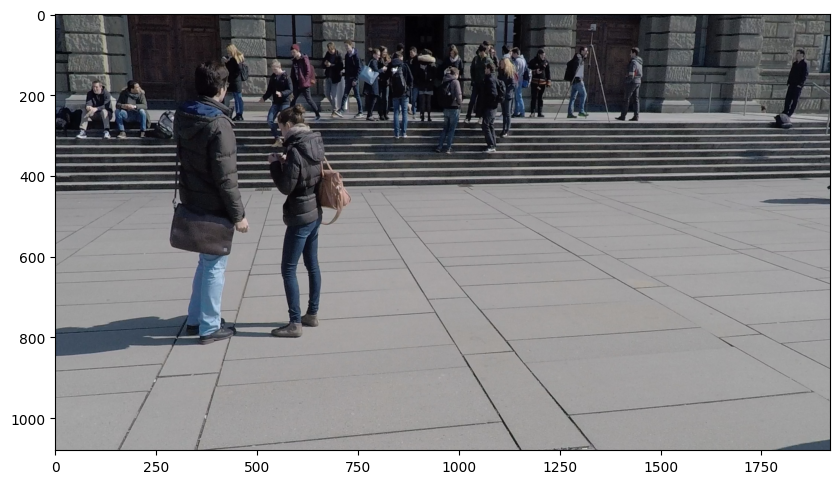

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [8]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [9]:
predictor.set_image(image)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

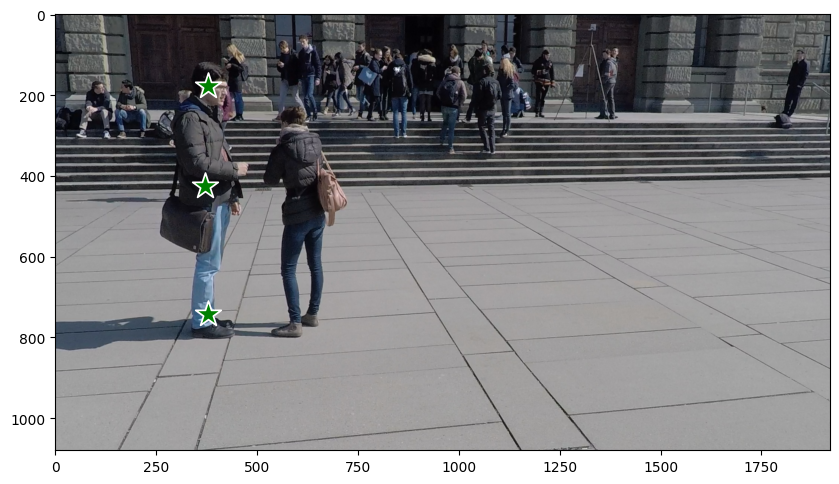

In [10]:
id = 106
str_id = f"{id:06d}.png"

image = cv2.imread('wildtrack_processed/images/' + str_id)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
annotations = json.load(open('annotations.json'))


input_point = np.array(annotations[str_id])
input_label = np.ones_like(input_point[:, 0])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [15]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [16]:
masks.shape  # (number_of_masks) x H x W

(1, 1080, 1920)

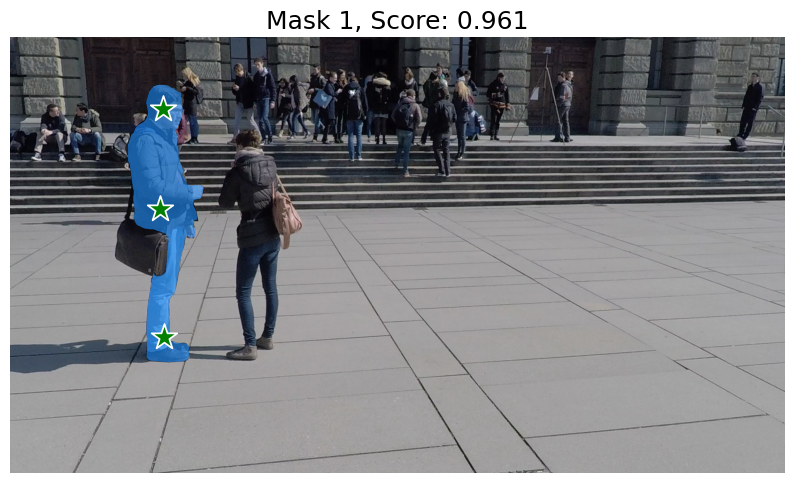

In [17]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [18]:
np.where(remove_small_regions(mask, 150, 'islands'))

(array([118, 118, 118, ..., 805, 805, 805], dtype=int64),
 array([366, 367, 368, ..., 396, 397, 398], dtype=int64))

In [12]:


def extract_mask(i, predictor, input_point, input_label):
    # 000012
    filename = f"{i:06d}"

    image = cv2.imread(f'wildtrack_processed/images/{filename}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    #SAVE mask to png file
    masks = masks[0]
    
    new_mask = remove_small_regions(masks, 1000, 'islands')
    
    new_mask = new_mask * 255
    new_mask = new_mask.astype(np.uint8)
    
    if "masks" not in os.listdir("wildtrack_processed"):
        os.mkdir("wildtrack_processed/masks")
    cv2.imwrite(f'wildtrack_processed/masks/{filename}.png', new_mask)


for i in tqdm(range(1, 191)):
    input_point = np.array(annotations[f"{i:06d}.png"])
    input_label = np.ones_like(input_point[:, 0])
    extract_mask(i, predictor, input_point, input_label)



TypeError: 'module' object is not callable

In [11]:

import cv2
import numpy as np
def cut_image(i):
    filename = f"{i:06d}"
    image = cv2.imread(f'wildtrack_processed/images/{filename}.png')
    mask = cv2.imread(f'wildtrack_processed/masks/{filename}.png')
    result = cv2.bitwise_and(image, mask)
    cv2.imwrite(f'wildtrack_processed/cut/{filename}.png', result)
    
for i in range(1, 381):
    cut_image(i)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:214: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'cv::binary_op'


In [4]:
!romp --mode=video --calc_smpl --render_mesh -i=C:\Users\Florian\Documents\segment-anything\notebooks\wildtrack_processed\cut -o=C:\Users\Florian\Documents\segment-anything\notebooks\wildtrack_processed\romp_cut

Using ROMP v1
ROMP 'forward' executed in 3.7415s, FPS 0.3
ROMP 'forward' executed in 0.1053s, FPS 9.5
ROMP 'forward' executed in 0.1074s, FPS 9.3
ROMP 'forward' executed in 0.1140s, FPS 8.8
ROMP 'forward' executed in 0.1111s, FPS 9.0
ROMP 'forward' executed in 0.1118s, FPS 8.9
ROMP 'forward' executed in 0.1222s, FPS 8.2
ROMP 'forward' executed in 0.1048s, FPS 9.5
ROMP 'forward' executed in 0.1133s, FPS 8.8
ROMP 'forward' executed in 0.1133s, FPS 8.8
ROMP 'forward' executed in 0.1138s, FPS 8.8
ROMP 'forward' executed in 0.1087s, FPS 9.2
ROMP 'forward' executed in 0.1167s, FPS 8.6
ROMP 'forward' executed in 0.1143s, FPS 8.7
ROMP 'forward' executed in 0.1103s, FPS 9.1
ROMP 'forward' executed in 0.1160s, FPS 8.6
ROMP 'forward' executed in 0.1094s, FPS 9.1
ROMP 'forward' executed in 0.1079s, FPS 9.3
ROMP 'forward' executed in 0.1052s, FPS 9.5
ROMP 'forward' executed in 0.1076s, FPS 9.3
ROMP 'forward' executed in 0.1333s, FPS 7.5
ROMP 'forward' executed in 0.1182s, FPS 8.5
ROMP 'forward' exe

C:\Users\Florian\anaconda3\envs\torch-ngp\lib\site-packages\romp\post_parser.py:34: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_ys = (topk_inds.long() // w).float()
C:\Users\Florian\anaconda3\envs\torch-ngp\lib\site-packages\romp\post_parser.py:39: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  topk_clses = index.long() // K
C:\

In [6]:
import numpy as np

#create a file called metadata.json with the following content
"""
{
  // Replace the string item_id with your file name of video frame.
  "item_id": {
        // A (72,) array: SMPL coefficients controlling body pose.
        "poses": [
            -3.1341, ..., 1.2532
        ],
        // A (10,) array: SMPL coefficients controlling body shape. 
        "betas": [
            0.33019, ..., 1.0386
        ],
        // A 3x3 camera intrinsic matrix.
        "cam_intrinsics": [
            [23043.9, 0.0,940.19],
            [0.0, 23043.9, 539.23],
            [0.0, 0.0, 1.0]
        ],
        // A 4x4 camera extrinsic matrix.
        "cam_extrinsics": [
            [1.0, 0.0, 0.0, -0.005],
            [0.0, 1.0, 0.0, 0.2218],
            [0.0, 0.0, 1.0, 47.504],
            [0.0, 0.0, 0.0, 1.0],
        ],
  }

  ...

  // Iterate every video frame.
  "item_id": {
      ...
  }
}
"""





def parse_results(i):
    
    filename = f"{i:06d}"
    result = np.load(f'wildtrack_processed/romp_cut/{filename}.npz', allow_pickle=True)['results'][()]
    return result 

output_filename = 'wildtrack_processed/metadata.json'

import xml.etree.ElementTree as ET
import numpy as np
import cv2
import os
filename = "extr_IDIAP1.xml"

# read the extrinsic and intrinsic calibration files
tree_ext = ET.parse(f'./wildtrack_raw/calibrations/extrinsic/{filename}')
tree_int = ET.parse(f'./wildtrack_raw/calibrations/intrinsic_original/{filename.replace("extr", "intr")}')
root = tree_ext.getroot()
rvec = root.find('rvec').text
tvec = root.find('tvec').text

root = tree_int.getroot()
camera_matrix = root.find('camera_matrix').find('data').text
dist_coeffs = root.find('distortion_coefficients').find('data').text

# convert the strings to numpy arrays
rvec = np.array([float(x) for x in rvec.split()])
tvec = np.array([float(x) for x in tvec.split()])
camera_matrix = np.array([float(x) for x in camera_matrix.split()]).reshape(3, 3)
dist_coeffs = np.array([float(x) for x in dist_coeffs.split()])

# convert the rotation vector to a rotation matrix
rotmat, _ = cv2.Rodrigues(rvec)


extr_mat = np.zeros((4, 4))
extr_mat[:3, :3] = rotmat
extr_mat[:3, 3] = tvec
extr_mat[3, 3] = 1

int_mat = camera_matrix



metadata = {}

for i in range(1, 381):
    res_dict = parse_results(i)
    poses = res_dict['smpl_thetas'][0]
    betas = res_dict['smpl_betas'][0]
    cam_intrinsics = int_mat
    cam_extrinsics = extr_mat
    metadata[f"{i:06d}"] = {
        "poses": poses.tolist(),
        "betas": betas.tolist(),
        "cam_intrinsics": cam_intrinsics.tolist(),
        "cam_extrinsics": cam_extrinsics.tolist()
    }
    
import json
with open(output_filename, 'w') as f:
    json.dump(metadata, f, indent=4)
    
    

In [7]:
parse_results(1)

{'cam': array([[ 0.38805202, -0.5702868 , -0.02401092]], dtype=float32),
 'global_orient': array([[-0.7471524 , -0.02615503, -2.8823411 ]], dtype=float32),
 'body_pose': array([[-2.0000975e-01,  2.1890888e-02,  1.8086687e-01, -3.0083197e-01,
         -1.4782982e-02, -1.1040848e-01,  2.2106600e-01, -4.7680482e-02,
         -1.3237710e-02,  3.7249646e-01, -8.1109479e-02, -5.7792280e-02,
          2.8952560e-01,  3.5615295e-02,  6.3390635e-02,  3.2765032e-03,
         -3.7723523e-02, -2.7507856e-02, -3.4867674e-02,  1.5326530e-01,
         -1.7027414e-01, -1.9995747e-02, -1.5313993e-01,  1.8201858e-01,
          6.9023006e-02, -3.4405265e-02, -1.5281159e-02, -1.5831408e-01,
          5.5150304e-02,  2.5386077e-01, -1.2012455e-01, -5.9778437e-02,
         -2.9010117e-01,  1.7341530e-02, -7.5149827e-02,  2.7808245e-02,
          1.5506514e-03, -2.0279785e-01, -8.0160655e-02, -1.1063500e-01,
          2.1145441e-01, -1.0863088e-01,  1.3863444e-01, -1.9902820e-03,
          1.6301773e-02,  1.